In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Environment setup**

In [2]:
!pip install fa2l

     |████████████████████████████████| 1.3MB 7.4MB/s 
  Created wheel for fa2l: filename=fa2l-0.2-cp36-none-any.whl size=8871 sha256=d13054fcd6f3eadf42c1d4822953af9d0c5280c1f6a2c204d627ab23165600dd
  Stored in directory: /root/.cache/pip/wheels/20/2f/62/09d4d24de06f3a33fbf9f038ad2745d0d5b265690dd98ee6f7
Successfully built fa2l
ERROR: scikit-image 0.16.2 has requirement networkx>=2.0, but you'll have networkx 1.11 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/fa2l-master

/content/drive/MyDrive/Colab Notebooks/fa2l-master


In [4]:
pwd


'/content/drive/MyDrive/Colab Notebooks/fa2l-master'

In [5]:
!python "setup.py" install


running install
running bdist_egg
running egg_info
writing fa2l.egg-info/PKG-INFO
writing dependency_links to fa2l.egg-info/dependency_links.txt
writing requirements to fa2l.egg-info/requires.txt
writing top-level names to fa2l.egg-info/top_level.txt
reading manifest file 'fa2l.egg-info/SOURCES.txt'
writing manifest file 'fa2l.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/fa2l
copying build/lib/fa2l/force.py -> build/bdist.linux-x86_64/egg/fa2l
copying build/lib/fa2l/__init__.py -> build/bdist.linux-x86_64/egg/fa2l
copying build/lib/fa2l/approximation.py -> build/bdist.linux-x86_64/egg/fa2l
copying build/lib/fa2l/fa2l.py -> build/bdist.linux-x86_64/egg/fa2l
copying build/lib/fa2l/structures.py -> build/bdist.linux-x86_64/egg/fa2l
byte-compiling build/bdist.linux-x86_64/egg/fa2l/force.py to force.cpython-36.pyc
byte-compiling build/bdist.linux-

# **Data setup**

In [8]:
df_domain = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cascade/domain_frequency.tsv",sep='\t')
df_domain.reset_index(drop=True, inplace=True)
df_domain

,domain,freq
0,nytimes.com,5721
1,theguardian.com,3824
2,reuters.com,3327
3,statnews.com,3204
4,washingtonpost.com,2885
...,...,...
12969,tn-elderlaw.com,1
12970,opinyon.net,1
12971,croxteth-hall.co.uk,1
12972,faktoje.al,1


In [9]:


df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cascade/tweets_labeled_us_en.tsv',sep='\t')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cascade/tweets_unlabeled_us_en.tsv',sep='\t')
df1.shape,df2.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((43566, 53), (89802, 53))

In [10]:
df = df1.append(df2)
df.columns

Index(['user_id', 'status_id', 'created_at', 'screen_name',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favorite_count', 'retweet_count',
       'quote_count', 'reply_count', 'hashtags', 'symbols', 'mentions_user_id',
       'mentions_screen_name', 'lang', 'quoted_status_id', 'quoted_created_at',
       'quoted_favorite_count', 'quoted_retweet_count', 'quoted_user_id',
       'quoted_screen_name', 'quoted_name', 'quoted_followers_count',
       'quoted_friends_count', 'quoted_statuses_count', 'retweet_status_id',
       'retweet_created_at', 'retweet_favorite_count', 'retweet_retweet_count',
       'retweet_user_id', 'retweet_screen_name', 'retweet_name',
       'retweet_followers_count', 'retweet_friends_count',
       'retweet_statuses_count', 'followers_count', 'friends_count',
       'listed_count', 'statuses_count', 'favourites_count',
       'account_created_at', 'in_degree', 'out_degree', 'cc', 'page_rank',
       'u

In [11]:

df = df[~df['domain'].isin(['twitter.com','facebook.com','youtube.com','google.com','reddit.com','instagram.com'])]


In [ ]:
df_domain =  df['domain'].value_counts().rename_axis('domain').reset_index(name='freq')
df_domain.to_csv("/content/drive/MyDrive/Colab Notebooks/cascade/domain_frequency.tsv",sep='\t',index=False)

In [12]:
df['polarity'].unique()

array(['Center', 'Lean Left', 'Lean Right', 'Right', 'Left', 'Mixed',
       'Neutral', nan], dtype=object)

In [13]:
df.loc[df['polarity'] == 'Lean Left', 'polarity'] = 'Left'
df.loc[df['polarity'] == 'Lean Right', 'polarity'] = 'Right'
df.loc[df['polarity'] == 'Center', 'polarity'] = 'Neutral'
# df.loc[df['polarity'] == 'Neutral', 'polarity'] = 'Center'

In [14]:
df_color = df[['domain','polarity']]
df_color.loc[df_color['polarity'] == 'Left', 'polarity'] = 'blue'
df_color.loc[df_color['polarity'] == 'Right', 'polarity'] = 'red'
df_color.loc[df_color['polarity'] == 'Neutral', 'polarity'] = 'gray'
df_color.loc[df_color['polarity'] == 'Mixed', 'polarity'] = 'green'
df_color.loc[df_color['polarity'].isna(), 'polarity'] = 'purple'
df_color['polarity'].unique()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

array(['gray', 'blue', 'red', 'green', 'purple'], dtype=object)

In [40]:
df_color['polarity'].unique()
# df_color

array(['gray', 'blue', 'red', 'green', 'purple'], dtype=object)

In [41]:
df_color1=df_color.drop_duplicates(subset=['domain'])
df_color1

,domain,polarity
0,cnbc.com,gray
3,reuters.com,gray
5,go.com,blue
9,washingtonexaminer.com,red
10,foxnews.com,red
...,...,...
89782,filmmunchin.com,purple
89790,cinemabang.com,purple
89797,jumpcutonline.co.uk,purple
89799,sarabangla.in,purple


In [51]:
df_domainlist = G.nodes
domainlist = [i for i in df_domainlist]
df12 = pd.DataFrame({'domain':domainlist}).merge(df_color1)
color_list = df12['polarity'].to_list()
df12
# len(color_list)
# domainlist
df_color1

,domain,polarity
0,cnbc.com,gray
3,reuters.com,gray
5,go.com,blue
9,washingtonexaminer.com,red
10,foxnews.com,red
...,...,...
89782,filmmunchin.com,purple
89790,cinemabang.com,purple
89797,jumpcutonline.co.uk,purple
89799,sarabangla.in,purple


## **Draw Network**

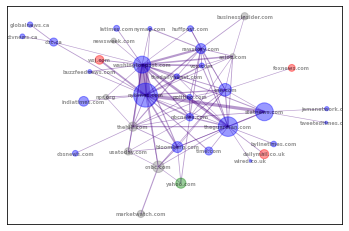

In [68]:
import networkx as nx
from fa2l import force_atlas2_layout
import matplotlib.pyplot as plt
import pandas as pd
import random

df_domain = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cascade/domain_frequency.tsv",sep='\t')
# G = nx.erdos_renyi_graph(100, 0.15, directed=False)
G =  nx.read_edgelist("/content/drive/MyDrive/Colab Notebooks/cascade/domain_net_above_5.edgelist", nodetype=str, data=(("Freq", int),))
df_domainlist = G.nodes
domainlist = [i for i in df_domainlist]
df11 = pd.DataFrame({'domain':domainlist}).merge(df_domain)
node_list = df11['freq'].to_list()
df12 = pd.DataFrame({'domain':domainlist}).merge(df_color1)
color_list = df12['polarity'].to_list()

positions = force_atlas2_layout(G,
                                iterations=1000,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=0.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=True,
                                barnes_hut_theta=0.5,

                                scaling_ratio=2.0,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=1.0)

wlist = [w['Freq']*0.1 for u,v,w in G.edges(data=True)]

nlist=[0.1*i for i in node_list]
fontlist = [0.1*i for i in node_list]
# nlist = node_list
colorlist = color_list

# nlist=[1 for i in G.nodes(data=True)]
# # nx.draw_networkx_nodes(G, positions, node_size=30,label=True, nodelist = nlist, node_color="blue",alpha=0.4)
# # nx.draw_networkx_edges(G, positions, edge_color="red",arrowsize=10,arrows=True, width = wlist,alpha=0.5)
nx.draw_networkx(G, positions,node_size=nlist,node_color=colorlist,edge_color="indigo",width = wlist,font_size = 5,alpha=0.4,with_labels=True,
                 label = "Graph",font_weight = 'bold')

# nx.draw_networkx(G, positions, cmap=plt.get_cmap('jet'), node_size=50, with_labels=False)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/cascade/graphsnaps/graph.pdf")
plt.show()

In [38]:
df_color


,domain,polarity
0,cnbc.com,gray
1,cnbc.com,gray
2,cnbc.com,gray
3,reuters.com,gray
4,reuters.com,gray
...,...,...
89796,indiewire.com,purple
89797,jumpcutonline.co.uk,purple
89798,avforums.com,purple
89799,sarabangla.in,purple


In [19]:
len(color_list),G.number_of_nodes(),len(df_domainlist)

(37, 37, 37)

In [ ]:
df.loc[df['domain'] == 'nytimes.com','user_id']

51                4698806923
54       1014836514935726080
57                   1767741
59                2914144864
80                1140665858
                ...         
42607              495415645
43122               20146913
43125               20146913
43214             1040080514
43379             1055383897
Name: user_id, Length: 5721, dtype: int64

In [ ]:
# pd.concat([df_domain, df_domain], axis=1, join="inner")
domain_freq = df_domain.merge(graph_domain, how='inner', on='domain')
domain_freq.columns

NameError: ignored

# **Probability Calculation**

In [54]:
# this dataframe is the nodes related with the graph  only 
df13 = df12.loc[df12['polarity'] == 'purple']
(df13)
unlabeled_list = df13['domain'].to_list()
unlabeled_list
# the main all domain color dataframe is the below
# df_color1

['tweetedtimes.com',
 'statnews.com',
 'jamanetwork.com',
 'cbc.ca',
 'ctvnews.ca',
 'globalnews.ca',
 'bylinetimes.com',
 'wired.co.uk',
 'indiatimes.com']

In [65]:
new_df_color1 = df_color1
iteration = 2

for iter in range(0,iteration):
  print('iteration##############################',iter)
  for i in unlabeled_list:
    neig=G.neighbors(i)
    dummylis=[]
    print('-------------',i)
    for x in neig:
      dummylis.append(x)
    print(dummylis)
    dummy_df = pd.DataFrame({'domain':dummylis}).merge(new_df_color1)
    dumy_color = dummy_df['polarity'].to_list()
    print(dumy_color)
    c=Counter(dumy_color)
    # print(c.values())
    
    blue_prob = c['blue']/sum(c.values())
    red_prob = c['red']/sum(c.values())
    gray_prob = c['gray']/sum(c.values())
    mixed_prob = c['green']/sum(c.values())
    
    if blue_prob > max(red_prob, gray_prob, mixed_prob):
      # df.loc[df['polarity'] == 'Lean Left', 'polarity'] = 'Left'
      new_df_color1.loc[new_df_color1['domain'] == i,'polarity'] = 'blue'
      # print(new_df_color1.loc[new_df_color1['domain'] == x,'polarity'])
      print(i,'---> blue')
    if red_prob > max(red_prob, gray_prob, mixed_prob):
      new_df_color1.loc[new_df_color1['domain'] == i,'polarity'] = 'red'
      print(i,'---->red')
    if gray_prob > max(red_prob, gray_prob, mixed_prob):
      new_df_color1.loc[new_df_color1['domain'] == i,'polarity'] = 'gray'
      print(i,'---->gray')
    if mixed_prob > max(red_prob, gray_prob, mixed_prob):
      new_df_color1.loc[new_df_color1['domain'] == i,'polarity'] = 'green'
      print(i,'---->green')
      
df_color1 = new_df_color1

iteration############################## 0
------------- tweetedtimes.com
['statnews.com']
['purple']
------------- statnews.com
['tweetedtimes.com', 'bloomberg.com', 'jamanetwork.com', 'nytimes.com', 'theguardian.com', 'washingtonpost.com', 'cnn.com', 'nbcnews.com']
['purple', 'blue', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue']
statnews.com ---> blue
------------- jamanetwork.com
['statnews.com']
['blue']
jamanetwork.com ---> blue
------------- cbc.ca
['nytimes.com', 'ctvnews.ca', 'globalnews.ca', 'washingtonpost.com']
['blue', 'purple', 'purple', 'blue']
cbc.ca ---> blue
------------- ctvnews.ca
['cbc.ca']
['blue']
ctvnews.ca ---> blue
------------- globalnews.ca
['cbc.ca']
['blue']
globalnews.ca ---> blue
------------- bylinetimes.com
['theguardian.com']
['blue']
bylinetimes.com ---> blue
------------- wired.co.uk
['theguardian.com']
['blue']
wired.co.uk ---> blue
------------- indiatimes.com
['nytimes.com']
['blue']
indiatimes.com ---> blue
iteration###########################

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


"\nprint('check:',new_df_color1.loc[new_df_color1['domain'] == 'statnews.com','polarity'])\n"